In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
from shapely.ops import nearest_points
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.geometry import Point, LineString
from src.shapes import *
from src.plots import *
from shapely.ops import linemerge

In [4]:
SHAPES_PATH = "/home/data/test/cities/C3562/transit_feeds/f-dr5r-mtanyctbusmanhattan/shapes.txt"
TRIPS_PATH = "/home/data/test/cities/C3562/transit_feeds/f-dr5r-mtanyctbusmanhattan/trips.txt"
ROUTES_PATH = "/home/data/test/cities/C3562/transit_feeds/f-dr5r-mtanyctbusmanhattan/routes.txt"

In [5]:
#SHAPES_PATH = "/home/data/test/cities/C3562/transit_feeds/f-dr5r-mtanyctbusbrooklyn/shapes.txt"
#TRIPS_PATH = "/home/data/test/cities/C3562/transit_feeds/f-dr5r-mtanyctbusbrooklyn/trips.txt"
#ROUTES_PATH = "/home/data/test/cities/C3562/transit_feeds/f-dr5r-mtanyctbusbrooklyn/routes.txt"

In [6]:
shapes = pd.read_csv(SHAPES_PATH)
trips = pd.read_csv(TRIPS_PATH)
routes = pd.read_csv(ROUTES_PATH)

In [7]:
gdf = prep_shapes(shapes)

In [8]:
gdf = gdf.merge(trips[["route_id", "trip_id", "shape_id", "direction_id"]].drop_duplicates(subset = ["route_id", "shape_id"]))

In [9]:
tree, nodes, G = get_node_data()

In [10]:
near_nodes, dists = ox.distance.nearest_nodes(G, shapes.shape_pt_lon, shapes.shape_pt_lat, return_dist = True)
shapes['nearest_node'] = near_nodes
shapes['node_dist'] = dists

In [11]:
shapes.query("shape_id == 'M010048'")

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,nearest_node,node_dist
0,M010048,40.73,-73.99,10001,42430872,8.20
1,M010048,40.73,-73.99,10002,42453104,2.01
2,M010048,40.73,-73.99,10003,42446528,15.25
3,M010048,40.73,-73.99,20001,42446528,15.25
4,M010048,40.73,-73.99,20002,42446528,0.48
...,...,...,...,...,...,...
310,M010048,40.82,-73.94,600002,2141026495,0.81
311,M010048,40.82,-73.94,600003,42439924,1.95
312,M010048,40.82,-73.94,600004,42439922,2.88
313,M010048,40.82,-73.94,600005,2141026521,1.42


In [12]:
nodes.query("osmid == 42430872")

,osmid,y,x,ref,highway,street_count,geometry
782,42430872,40.73,-73.99,NaN,traffic_signals,4,POINT (-73.99035 40.73128)


In [13]:
# Apply the function to each geometry in the GeoDataFrame
gdf['first_point'] = gdf['geometry'].apply(get_first_point)
gdf['last_point'] = gdf['geometry'].apply(get_last_point)

first_points = np.array([gdf['first_point'].y, gdf['first_point'].x]).T
last_points = np.array([gdf['last_point'].y, gdf['last_point'].x]).T

gdf["first_node"] = tree.query(first_points, k=1, return_distance=False)
gdf["last_node"] = tree.query(last_points, k=1, return_distance=False)

gdf['nearest_osm_id_start'] = gdf['first_node'].map(nodes['osmid'])
gdf['nearest_osm_id_stop'] = gdf['last_node'].map(nodes['osmid'])

In [74]:
def all_paths_from_node(G, start_node, path_length, visited = []):
    paths = []
    geometries = []

    def dfs(node, path, geometry, depth):
        if depth == path_length:
            # Path has reached the required length
            paths.append(path)
            geometries.append(linemerge(geometry))
            return
        
        for neighbor in G.neighbors(node):
            if neighbor not in path and neighbor not in visited:  # Avoid revisiting nodes within the same path
                # Get edge data
                edge_data = G.get_edge_data(node, neighbor)
                
                # Handle the case of MultiGraph (multiple edges between nodes)
                if G.is_multigraph():
                    for key in edge_data:
                        geom = edge_data[key].get('geometry')
                        if geom:
                            dfs(neighbor, path + [neighbor], geometry + [geom], depth + 1)
                else:
                    geom = edge_data.get('geometry')
                    if geom:
                        dfs(neighbor, path + [neighbor], geometry + [geom], depth + 1)

    dfs(start_node, [start_node], [], 0)
    return paths, geometries 

def get_next_path(path, route_linestring, G, path_length=1, max_length = 5, img_path=None, cumulative_linestring=None, debug_output=False):
    paths, geoms = all_paths_from_node(G, path[-1], path_length, path)
    min_distance = np.Inf
    best_geom = None
    best_path = None

    for path, geometry in zip(paths, geoms):
        if best_geom is None:
            best_geom = geometry
            best_path = path
    
        distance = compare_linestrings(geometry, route_linestring)

        if debug_output:
            plt.show(plot_two_lines(route_linestring, geometry))
            print(distance)

        if img_path is not None:
            plot_two_lines(route_linestring, cumulative_linestring, geometry, img_path=f"{img_path}_{v}.png")

        if distance < min_distance:
            min_distance = distance
            best_path = (path, geometry, distance)

    #if best_path[2] > 1e-8 and path_length < max_length:
    #    print(f"Trying paths of length {path_length + 1}")
    #    get_next_path(start_node, route_linestring, G, visited, path_length+1, max_length, img_path=None, cumulative_linestring=None, debug_output=False)

    if best_path:
        
        return {
            'path': best_path[0],
            'geometry': best_path[1],
            'distance': best_path[2]
        }
    
def get_route_shape(path, stop_node, bus_shape, G, path_length = 1, img_path = None, debug = False, threshold = 1e-8):
    i = 0
    out_shape = None
    out_df = pd.DataFrame()

    while stop_node not in path and i < 1000:

        if img_path is not None:
            out = get_next_path(path, bus_shape, G, path_length=path_length, img_path = f"{img_path}/frame_{i}", cumulative_linestring=out_shape)
        else:
            out = get_next_path(path, bus_shape, G, path_length=path_length)

        if out is None:
            print("got to bad node")
            break
        
        if not out_shape:
            out_shape = out["geometry"]
        else:
            out_shape = concatenate_linestrings(out_shape, out["geometry"])

        out["cumulative_linestring"] = out_shape

        if debug:
            print(out['path'])
            print(out['distance'])
            plot_two_lines(bus_shape, out["cumulative_linestring"])

        temp_df = temp_df = pd.DataFrame({
            'path': [out['path']],
            'geometry': [out['geometry']],
            'distance': [out['distance']],
            'cumulative_linestring': [out['cumulative_linestring']]
        }, index=[i])

        out_df = pd.concat([out_df, temp_df])
        if img_path is not None:
            plot_two_lines(bus_shape, out_shape, img_path = f"{img_path}/frame_{i}")

        if stop_node in out['path']:
            stop_index = out['path'].index(stop_node)
            path = path + out['path'][1:stop_index+1]
        else: 
            path = path + out['path'][1:]

        if out["distance"] > threshold:
            print("No good path found")
            break
        i += 1
    
    return out_df

In [75]:
test_route = gdf.query("shape_id == 'M030050'")
#test_route = gdf.query("route_id == 'M96'")


start_node = test_route["nearest_osm_id_start"].iloc[0]
stop_node = test_route["nearest_osm_id_stop"].iloc[0]
bus_shape = test_route["geometry"].iloc[0]

#test = get_next_node(start_node, bus_shape, G)


In [76]:
start_node = test_route["nearest_osm_id_start"].iloc[0]
stop_node = test_route["nearest_osm_id_stop"].iloc[0]
bus_shape = test_route["geometry"].iloc[0]
visited = {}

out = get_route_shape([start_node], stop_node, bus_shape, G, path_length = 2)

No good path found


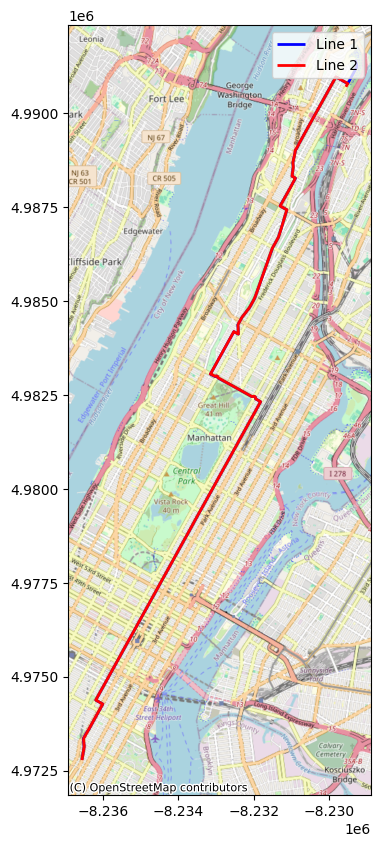

In [77]:
p = plot_two_lines(bus_shape, out.tail(1).cumulative_linestring.iloc[0])

In [51]:
out_gdf = gpd.GeoDataFrame(out, geometry = "geometry").drop("cumulative_linestring", axis = 1)

In [63]:
out_shapes = pd.DataFrame()

for shape in shapes.shape_id.drop_duplicates():
    print(shape)
    route = gdf.query("shape_id == @shape")
    start_node = route["nearest_osm_id_start"].iloc[0]
    stop_node = route["nearest_osm_id_stop"].iloc[0]
    bus_shape = route["geometry"].iloc[0]
    visited = {}
    i = 1
    temp = None  # Initialize temp to avoid reference before assignment in case of an exception
    while i <= 5:
        try:
            temp = get_route_shape([start_node], stop_node, bus_shape, G, path_length=2).tail(1).drop('geometry', axis=1)
            temp["shape_id"] = shape
            break
        except Exception as e:
            print(f"Failed at i = {i}: {e}")
            i += 1

    if temp is not None:
        out_shapes = pd.concat([out_shapes, temp], ignore_index=True)
    else:
        print(f"Could not find a valid route for shape {shape} after {i-1} attempts.")



M010048
M010049
M010052
M010054
M010055
M010056
M020033
M020034
M020035
M020036
M020037
M020038
M020202
M030041
M030043
got to bad node
M030045
got to bad node
M030050
got to bad node
M030051
M030057
M030058
M040016
M040038
M040112
got to bad node
M040114
M040116
M040117
M040118
M040119
M040127
M040128
M040129
M040130
M040131
M050020
M050021
M050022


KeyboardInterrupt: 

In [ ]:
temp

In [ ]:
out_shapes = gpd.GeoDataFrame(out_shapes, geometry = "cumulative_linestring")

In [ ]:
gdf1 = out_shapes.set_crs(4326).to_crs(epsg=3857)
gdf2 = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf1.plot(ax=ax, edgecolor='blue', linewidth=2, label='Out shapes')
gdf2.plot(ax=ax, edgecolor='red', linewidth=2, label='GTFS Shapes', linestyle='--')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.legend()


In [ ]:
out_shapes

In [ ]:

# Function to extract the minimum x-coordinate from a LineString
def min_x_coordinate(linestring):
    return min(coord[1] for coord in linestring.coords)

# Apply the function to create a new column with the minimum x-coordinate of each LineString
gdf1['min_x'] = gdf1['cumulative_linestring'].apply(min_x_coordinate)

# Get the row with the minimum x-coordinate
min_x_row = out_shapes.loc[gdf1['min_x'].idxmin()]

# Optionally, you can drop the 'min_x' column if no longer needed
gdf1 = gdf1.drop(columns=['min_x'])

min_x_row

In [ ]:
min_x_row.merge(gdf)

In [ ]:
route = gdf.query("route_id == 'M9'")
start_node = route["nearest_osm_id_start"].iloc[0]
stop_node = route["nearest_osm_id_stop"].iloc[0]
bus_shape = route["geometry"].iloc[0]
visited = {}

out = get_route_shape(start_node, stop_node, bus_shape, visited, img_path = "plots/M9")

In [ ]:
create_gif_from_folder("plots/M9", "plots/M9.gif", duration=1)

In [ ]:
out["distance"].hist()